# Binaries

In [1]:
from spice.models.binary import Binary, add_orbit, evaluate_orbit_at_times
from spice.models.mesh_model import IcosphereModel
from spice.models.mesh_view import get_mesh_view
import matplotlib.pyplot as plt
import numpy as np
import astropy.units as u
from spice.spectrum import simulate_observed_flux
from transformer_payne import Blackbody
import jax.numpy as jnp
%matplotlib inline

from jax import config
config.update('jax_platform_name', 'cpu')

A binary system can be instantiated with creating two separate mesh models. No position transformation needs to be applied - the Keplerian orbit is then calculated and bodies are moved in corresponding timesteps.

To apply the necessary transformation:
1. ```add_orbit``` needs to be called to add the orbit information
2. ```evaluate_orbit``` or ```evaluate_orbit_at_times``` (for multiple timesteps) needs to be called - the bodies are modified with the parameters calculated for a Keplerian orbit here.

The timestamps (```times```) are chosen so that the occlusion is captured.

In [11]:
def default_icosphere():
    return get_mesh_view(IcosphereModel.construct(1000, 1., 1., [5700, 0.], ['teff', 'abun']), jnp.array([0., 1., 0.]))

body1 = default_icosphere()
body2 = default_icosphere()
binary = Binary.from_bodies(body1, body2)
binary = add_orbit(binary, 1., 0., 0., 0., 0., 0., 10)
times = jnp.linspace(0.245, 0.255, 50)
pb1, pb2 = evaluate_orbit_at_times(binary, times)

/Users/mjablons/Documents/stellar-mesh-integration/src/spice/models/mesh_model.py:231: UserWarning: If override_log_g is True, either parameter_names must include one of [logg,loggs,log_g,log_gs,log g,log gs,surface gravity,surface gravities,surface_gravity,surface_gravities], or log_g_index must be passed for log g to be used in the spectrum emulator.
  warnings.warn(f"If override_log_g is True, either parameter_names must include one of [" + ",".join(


Let's use the simplest blackbody model for speed.

(<Figure size 1000x1200 with 2 Axes>,
 <Axes3DSubplot:xlabel='$X [R_\\odot]$', ylabel='$Y [R_\\odot]$'>)

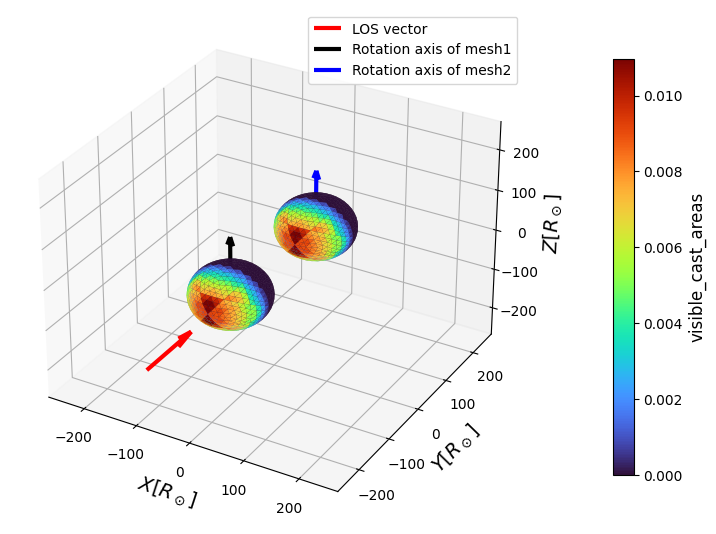

In [12]:
from spice.plots.plot_mesh import plot_3D_binary

i = 0
plot_3D_binary(pb1[i], pb2[i], property='visible_cast_areas', scale_radius=70)

Let's evaluate the orbit to create arrays of meshes with calculated parameters.

## Synthetic photometry

Let's calculate the observed flux (for the default value of $d=10$ pc) for both components. To obtain the result flux, we need to sum the both parameters.

In [22]:

from tqdm import tqdm

bb = Blackbody()
ws = np.linspace(900, 40000, 1000)
s1s = [simulate_observed_flux(bb.intensity, _pb1, np.log10(ws)) for _pb1 in tqdm(pb1)]
s2s = [simulate_observed_flux(bb.intensity, _pb2, np.log10(ws)) for _pb2 in tqdm(pb2)]

100%|██████████| 50/50 [00:00<00:00, 138.96it/s]


In [14]:
from spice.spectrum import AB_passband_luminosity
from spice.spectrum.filter import JohnsonV, GaiaG, Bolometric

johnsonV = JohnsonV()
lums_johnson_v = [AB_passband_luminosity(johnsonV, ws, s1[:, 0]+s2[:, 0]) for s1, s2 in zip(s1s, s2s)]
gaia_g = GaiaG()
lums_gaia_g = [AB_passband_luminosity(gaia_g, ws, s1[:, 0]+s2[:, 0]) for s1, s2 in zip(s1s, s2s)]
bolometric = Bolometric()
lums_bolometric = [AB_passband_luminosity(bolometric, ws, s1[:, 0]+s2[:, 0]) for s1, s2 in zip(s1s, s2s)]

We can plot the spectrum changes:

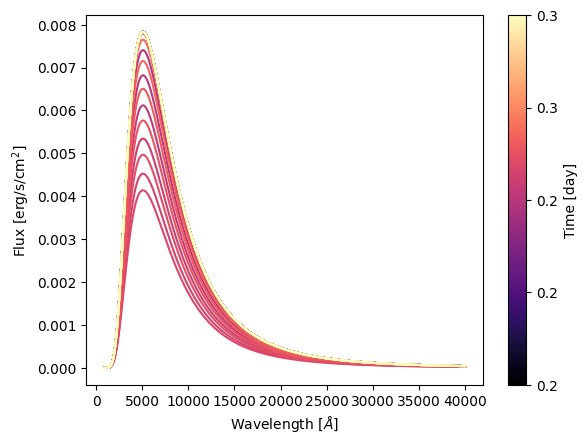

In [29]:
from matplotlib.cm import magma

norm = plt.Normalize(0, len(s1s)-1)
for i, (_s1, _s2) in enumerate(zip(s1s, s2s)):
    plt.plot(ws, _s1[:, 0]+_s2[:, 0], color=magma(norm(i)))
plt.colorbar(plt.cm.ScalarMappable(norm=norm, cmap=magma), label='Time [day]', ticks=np.linspace(0, len(s1s)-1, 5)).set_ticklabels(np.round(times[::len(times)//5], 1))


plt.gca().set_xlabel('Wavelength [$\AA$]')
plt.gca().set_ylabel('Flux [erg/s/cm$^2$]')
plt.show()

And the corresponding lightcurves:

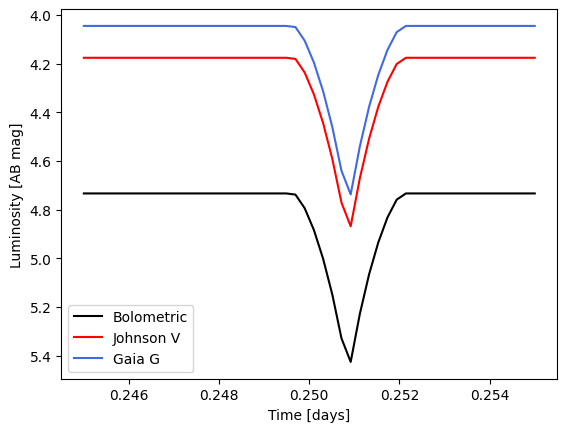

In [21]:
plt.plot(times, lums_bolometric, color='black', label='Bolometric')
plt.plot(times, lums_johnson_v, color='red', label='Johnson V')
plt.plot(times, lums_gaia_g, color='royalblue', label='Gaia G')
plt.gca().invert_yaxis()
plt.legend()
plt.gca().set_xlabel('Time [days]')
plt.gca().set_ylabel('Luminosity [AB mag]')
plt.show()